In [1]:
# TO BE RUN ONLY ONCE!
import os
os.chdir("../")

In [2]:
## *******************************************************************************

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

import spatial_mix.hdp_utils as hdp_utils
from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

## Simulate data

<img src="simulation_scenario.png">

Simulate data as follows: for each little square we simulate data from a 3 components mixtures
$$ y_{ij} \sim w_{i1} N(-5, 1) + w_{i2} N(0, 1) + w_{i3} N(5, 1)$$

the weights depend on the location (x, y) of the center of the square (the orange dot)
$$ \widetilde{w}_{il} = \alpha_l x_i + \beta_l y_i \quad l=1, 2$$

finally $w_i = alr^{-1} ([\widetilde{w}_{i1}, \widetilde{w}_{i2}])$

In [32]:
def inv_alr(x):
    out = np.exp(np.hstack((x, 1)))
    return out / np.sum(out)

In [33]:
def simulate_from_mixture(weights):
    means = [-5, 0, 5]
    comp = np.random.choice(3, p=weights)
    return np.random.normal(loc=means[comp], scale=1)

In [37]:
centers = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 0], [1, 0], [2, 0], [3, 0]])
centers = centers / 10
alpha1 = 0.3
alpha2 = -0.3
beta1 = 0.3
beta2 = -0.3

weights = []
for center in centers:
    w1 = alpha1 * center[0] + beta1 * center[1]
    w2 = alpha2 * center[0] + beta2 * center[1]
    weights.append(inv_alr([w1, w2]))

In [82]:
Dmat1 = np.zeros((8, 8))

for i in range(7):
    Dmat1[i, i+1] = 1
    Dmat1[i+1, i] = 1
    if (i < 4):
        Dmat1[i, i+4] = 1
        Dmat1[i+4, i] = 1
    
print(Dmat1)

[[0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0.]]


In [39]:
np.savetxt("data/simulated_D1.csv", Dmat1, delimiter=",")

In [40]:
data = []
for i in range(8):
    numSamples = 100
    if i == 5:
        numSamples = 20
        
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])

In [41]:
df = pd.DataFrame(data, columns=["group", "data"])
df.to_csv("data/simulated_data1.csv", index=False)

# Simulated Scenario 2

In [83]:
Dmat2 = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
]) 

print(Dmat2)

[[0 1 1 1 0 0 0 0]
 [1 0 1 1 0 0 0 0]
 [1 1 0 1 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 0]]


In [171]:
w_group1 = np.array([0.25, 0.25, 0.5])
w_group2 = np.array([0.4, 0.4, 0.2])

weights = []

data = []
for i in range(8):
    numSamples = 1000
#     if i == 5:
#         numSamples = 20
    
    w = w_group1 if i < 4 else w_group2
    weights.append(w)
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(w)])
        
df = pd.DataFrame(data, columns=["group", "data"])
df.to_csv("data/simulated_data2.csv", index=False)
np.savetxt("data/simulated_D2.csv", Dmat2, delimiter=",")

# call C++ from terminal

In [188]:
subprocess.call(
    "./spatial_mix/run_from_file.out"
    " data/simulated_data2.csv"
    " data/simulated_D2.csv"
    " data/chains_simulated2.recordio".split())

0

In [155]:
print("./spatial_mix/run_from_file.out"
    " data/simulated_data2.csv"
    " data/simulated_D2.csv"
    " data/chains_simulated2.recordio")

./spatial_mix/run_from_file.out data/simulated_data2.csv data/simulated_D2.csv data/chains_simulated2.recordio


## Plot density estimates

In [189]:
df = pd.read_csv("data/simulated_data2.csv")
chains = loadChains("data/chains_simulated2.recordio")

In [190]:
datas = []
for g in range(8):
    datas.append(df[df.group == g].data.values)

In [191]:
xgrid = np.linspace(-10, 10, 1000)
dens = estimateDensities(chains, xgrid)

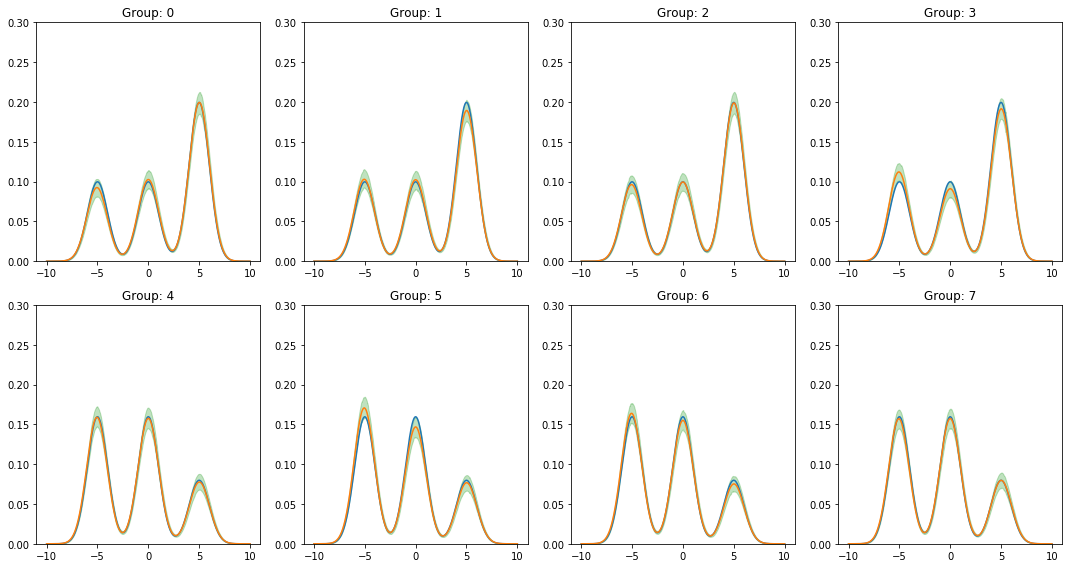

In [193]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.3])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
#     sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [194]:
estimateds = estimateDensities(chains, datas)
lpml(estimateds)

821.6498301187592

In [153]:
print(pd.DataFrame(np.array(sigmaChain[-1].data).reshape(9, 9)))

          0         1         2         3         4         5         6  \
0  0.081482 -0.010803 -0.023707 -0.008619 -0.010616  0.001162  0.035103   
1 -0.010803  0.059412  0.020962 -0.019054  0.000658 -0.026661 -0.003955   
2 -0.023707  0.020962  0.117120 -0.009675 -0.013165 -0.040071 -0.047828   
3 -0.008619 -0.019054 -0.009675  0.064851 -0.001745  0.028764  0.009515   
4 -0.010616  0.000658 -0.013165 -0.001745  0.042045 -0.016586 -0.009847   
5  0.001162 -0.026661 -0.040071  0.028764 -0.016586  0.095794  0.035227   
6  0.035103 -0.003955 -0.047828  0.009515 -0.009847  0.035227  0.082228   
7 -0.053074  0.012339  0.023831 -0.024641  0.050331 -0.072489 -0.081832   
8  0.001597 -0.003865  0.024010  0.004802 -0.003655 -0.011803 -0.009576   

          7         8  
0 -0.053074  0.001597  
1  0.012339 -0.003865  
2  0.023831  0.024010  
3 -0.024641  0.004802  
4  0.050331 -0.003655  
5 -0.072489 -0.011803  
6 -0.081832 -0.009576  
7  0.275791  0.025989  
8  0.025989  0.041165  


## Hdp

In [99]:
subprocess.call(
    "./spatial_mix/run_hdp_from_file.out"
    " data/simulated_data2.csv"
    " data/chains_hdp_simulated2.recordio".split())

0

In [113]:
hdpChains = loadChains("data/chains_hdp_simulated2.recordio", HdpState)

In [116]:
xgrid = np.linspace(-10, 10, 1000)
densHdp = hdp_utils.estimateDensities(hdpChains, xgrid)

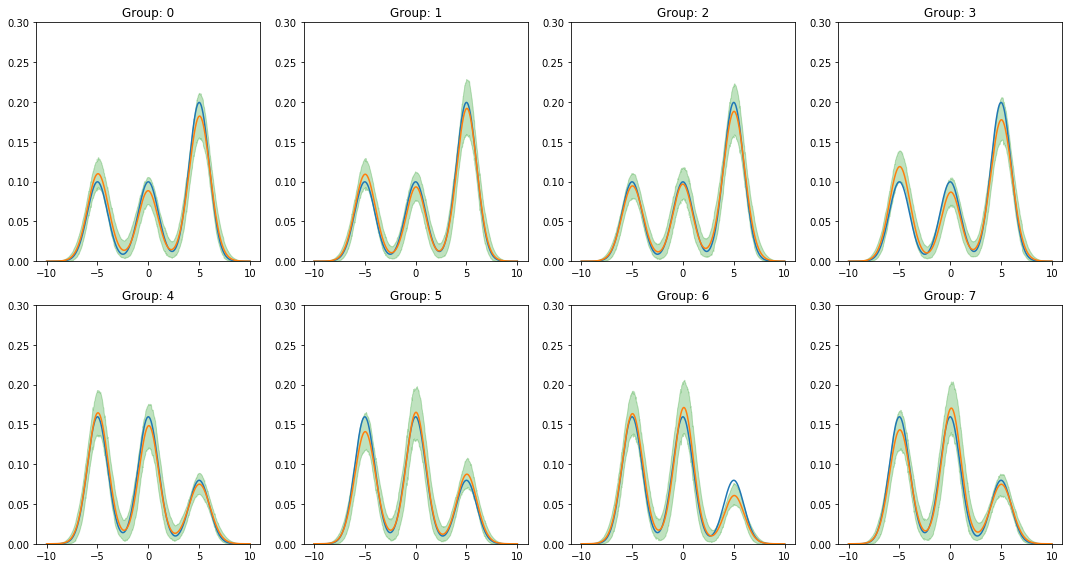

In [117]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    obs = df[df["group"] == g]["data"].values
    # sns.kdeplot(obs, ax=axes[g])
    axes[g].set_ylim([0, 0.3])
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    intervals = np.array([pm.stats.hpd(densHdp[g][:, i], 0.05) for i in range(densHdp[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
    
plt.tight_layout()

In [104]:
estimatedHdp = hdp_utils.estimateDensities(hdpChains, datas)
lpml(estimatedHdp)

161.00303262952536

In [107]:
lpml(estimatedHdp[2])

19.375868674786428

In [108]:
lpml(estimateds[2])

19.12351678076545